In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from shapely.geometry import Point, LineString, Polygon
import torch
import numpy as np

def ffsGeo(Ho, Lo):
    xMax = 12
    xMin = -6
    Wo = 0.1
    bPoints = [
        Point(xMin, 0.5), Point(-Lo, 0.5), Point(-Lo, 0.5 - Ho),
        Point(-Lo + Wo, 0.5 - Ho), Point(-Lo + Wo, 0.5), Point(0, 0.5),
        Point(0, 0), Point(xMax, 0), Point(xMax, -0.5), Point(xMin, -0.5),
        Point(xMin, 0.5)
    ]
    geo = Polygon(bPoints)
    boundary = LineString(bPoints)
    return {'boundary': boundary, 'geo': geo}

def signed_distance(p, shape):
    pt = Point(p)
    d = pt.distance(shape['boundary'])
    return d if shape['geo'].contains(pt) else -d

def evalPointCloud(xMin, xMax, Ho, Lo, totalPoints):
    # Generate the full point cloud
    aspect = (xMax - xMin) / 1
    Ny = int(np.sqrt(totalPoints / aspect))
    Nx = int(totalPoints / Ny)

    x = np.linspace(xMin, xMax, Nx)
    y = np.linspace(-0.5, 0.5, Ny)
    X, Y = np.meshgrid(x, y)
    points = np.stack([X.ravel(), Y.ravel()], axis=1)

    # Compute SDF
    geo = ffsGeo(Ho=Ho, Lo=Lo)
    sdf = np.array([signed_distance(p, geo) for p in points])

    mask = (sdf >= 0)
    insidePoints = points[mask]
    insideSdf = sdf[mask]

    return {
        'input_feat': torch.tensor(insideSdf, dtype=torch.float32),
        'input_pos': torch.tensor(insidePoints, dtype=torch.float32)
    }

In [7]:
from upt.datasets.ffs_dataset import ffsDataset

# crop_values= [[-6, -2], [12, 2]]
crop_values= [[-2, -2], [2, 2]]

xMin = crop_values[0][0]
xMax = crop_values[1][0]

# num_test_inputs  = 4096
# num_test_outputs = 4096
# num_train_inputs  = num_test_inputs 
# num_train_outputs = num_test_outputs

test_hr_dataset = ffsDataset(
    root="./data/ffs/preprocessed",
    # how many inputs to use for training
    # num_inputs=float("inf"),
    num_inputs=40000,
    # how many outputs to use for training
    # num_outputs=float("inf"),
    num_outputs=40000,
    # mode
    mode="test",
    crop_values=crop_values,
)
from torch.utils.data import DataLoader
from upt.collators.ffs_collator import ffsCollator

# get test sample
test_dataloader = DataLoader(
    dataset=test_hr_dataset,
    batch_size=1,
    collate_fn=ffsCollator(num_supernodes=512, deterministic=True),
)
data = [d for d in test_dataloader]

In [8]:
batch = data[2]
input_pos = test_hr_dataset.denormalize_pos(batch['input_pos'])
sdf = test_hr_dataset.denormalize_sdf(batch['input_feat'])

name = batch['name'][0]
parameters = name.split('_')[1].replace(',', '.').split('-')
re = float(parameters[0])
Lo = float(parameters[1])
Ho = float(parameters[2])

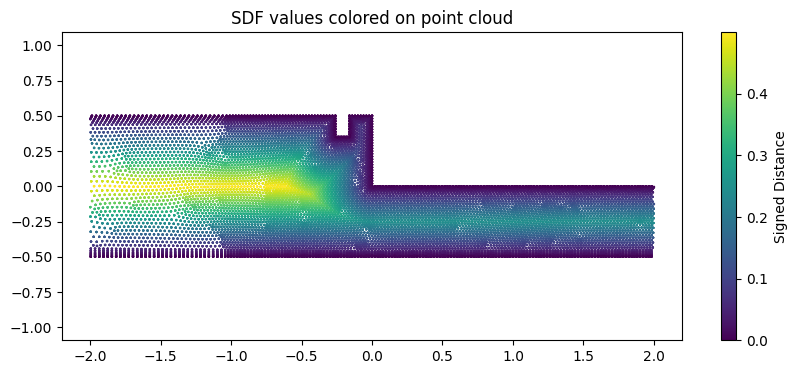

In [9]:
import matplotlib.pyplot as plt

# Visualize
plt.figure(figsize=(10, 4))
plt.scatter(input_pos[:, 0], input_pos[:, 1], c=sdf, s=0.5)
plt.colorbar(label="Signed Distance")
plt.axis("equal")
plt.title("SDF values colored on point cloud")
plt.show()

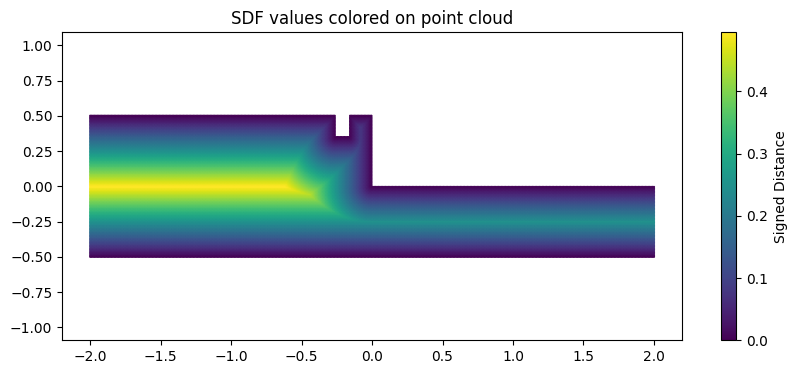

In [10]:
import matplotlib.pyplot as plt

pointCloud = evalPointCloud(
    xMin=xMin,
    xMax=xMax,
    Ho=Ho, Lo=Lo,
    totalPoints=40000
)

# Visualize
plt.figure(figsize=(10, 4))
plt.scatter(pointCloud['input_pos'][:, 0], pointCloud['input_pos'][:, 1], c=pointCloud['input_feat'], s=0.5)
plt.colorbar(label="Signed Distance")
plt.axis("equal")
plt.title("SDF values colored on point cloud")
plt.show()
# ['892.50000000000591', '0.87000000000000477', '0.33700000000000008']


In [3]:
directory = './data/ffs/preprocessed/DP1_718,18181818181733-0,43636363636363645-0,10181818181818182/'
mesh_tensor = torch.load('/workspace/upt-tutorial/data/simulation/case_000000/00000000_mesh.th', weights_only=True)

In [11]:
sdf = torch.load(uri.replace('CSV', 'preprocessed').replace('.csv', '/') + 'mesh_sdf.th', weights_only=True)
mesh_pos = torch.load(uri.replace('CSV', 'preprocessed').replace('.csv', '/') + 'mesh_points.th', weights_only=True)


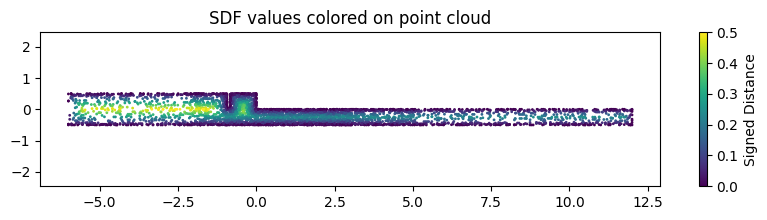

In [ ]:
# Visualize
plt.figure(figsize=(10, 2))
plt.scatter(input_pos[:, 0], input_pos[:, 1], c=input_feat, s=1)
plt.colorbar(label="Signed Distance")
plt.axis("equal")
plt.title("SDF values colored on point cloud")
plt.show()

In [60]:
import torch
# /workspace/upt-tutorial/data/ffs/preprocessed/coords_norm.th
                    #  ../data/ffs/preprocessed/coords_norm.th
# Load tensor data
directory = './data/ffs/preprocessed600/'
coords_norm = torch.load(directory + 'coords_norm.th')
vars_norm = torch.load(directory + 'vars_norm.th')

/tmp/ipykernel_155353/579588111.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  coords_norm = torch.load(directory + 'coords_norm.th')
/tmp/ipykernel_155353/579588111.py

In [61]:
vars_norm

{'mean': tensor([ 1.6302, -0.0438,  5.1136,  0.1240]),
 'std': tensor([1.2665, 0.1466, 3.7823, 0.1178])}

In [20]:
sum_vars = 0.0
sum_sq_vars = 0.0
total_samples = 0
for uri in uris:
    sdf = torch.load(uri / 'mesh_sdf.th', weights_only=True)
    sum_vars += sdf.sum()
    sum_sq_vars += (sdf ** 2).sum()
    total_samples += len(sdf)
mean_vars = sum_vars / total_samples
std_vars = torch.sqrt((sum_sq_vars / total_samples) - (mean_vars ** 2))
other = torch.load(root/'vars_norm.th', weights_only=True)
other['mean'][-1] = mean_vars
other['std'][-1] = std_vars
torch.save(other, root/"vars_norm.th")
